<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорты-и-необходимые-функции" data-toc-modified-id="Импорты-и-необходимые-функции-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорты и необходимые функции</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-просмотр" data-toc-modified-id="Загрузка-данных-и-просмотр-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Загрузка данных и просмотр</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Деревья" data-toc-modified-id="Деревья-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Деревья</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итог" data-toc-modified-id="Итог-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итог</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорты и необходимые функции

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install catboost -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install imblearn -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
#Импортируем необходимые библиотеки для работы 
import pandas as pd
from math import *
import numpy as np
from scipy import stats as st
from sqlalchemy import create_engine 

# Метрики и оОбработка данных
from imblearn.combine import SMOTETomek
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder)

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit

# Графическое отображение
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap
from statsmodels.tsa.seasonal import seasonal_decompose

# Модели обучения
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

#Зададим константы
TEST_SIZE = 0.1
RANDOM_STATE = 42

In [7]:
def prepare_data(X, y):
   
    X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    shuffle = False)
    
    return X_train, X_test, y_train, y_test

In [8]:
# Функция для отображения информации о датасете
def show_info(df):
    print('Количество строк выборки составляет:',df.shape[0],'\n',"=="*50)
    display("Первые пять строк", df.head())
    print('Общая информация о данных\n','=='*50)
    print(df.info())
    display('Описание',df.describe().T,"=="*50)
    print('Количество явных дубликатов составляет',df.duplicated().sum())

In [9]:
# Функция отображения гистограм и боксплотов для исследовательского анализа
def search_plot(df_col, title_name, bins):

    mean = df_col.mean()
    median = df_col.median()
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"{title_name}", fontsize=13)
    
    sns.histplot(df_col, bins=bins, kde=True, ax=ax[0])
    ax[0].set_title('Гистограмма', fontsize=10)
    ax[0].set_xlabel(title_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)
    
    ax[0].axvline(mean, color='red', linestyle='--', label=f'Среднее = {mean:.2f}')
    ax[0].axvline(median, color='purple', linestyle='-.', label=f'Медиана = {median:.2f}')
    ax[0].legend()

    sns.boxplot(x=df_col, ax=ax[1], color='pink')
    ax[1].set_title('Диаграмма размаха', fontsize=10)
    ax[1].axvline(median, color='green', linestyle='-.')
    ax[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    
    display(df_col.describe().T)
    print('')
    
    stat, p = st.shapiro(df_col)
    alpha = 0.1  # Уровень значимости
    if p > alpha:
        print("По тесту Шапиро-Уилка: Распределение похоже на нормальное")
    else:
        print("По тесту Шапиро-Уилка: Распределение отличается от нормального")

## Подготовка

### Загрузка данных и просмотр

In [10]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [11]:
show_info(df)

Количество строк выборки составляет: 26496 


'Первые пять строк'

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


'===================================================================================================='

Количество явных дубликатов составляет 26415


In [12]:
print('Кол-во пропусков в данных составляет:', df.isna().sum())

Кол-во пропусков в данных составляет: num_orders    0
dtype: int64


In [13]:
df = df.sort_index()

In [14]:
print(df.index.is_monotonic)

True


In [15]:
print(' Начальная дата:',df.index[0],'\n',
       'Конечная дата:',df.index[-1])

 Начальная дата: 2018-03-01 00:00:00 
 Конечная дата: 2018-08-31 23:50:00


В данных пропусков нет, индекс монотонный.     
Данные представлены за 6 месяцев работы.     
Замечаний нет, сделаем ресемпл данных по часовым значениям

In [16]:
# ресемплинг - среднее по каждому часу
df = df.resample('1H').sum()

In [17]:
show_info(df)

Количество строк выборки составляет: 4416 


'Первые пять строк'

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


'===================================================================================================='

Количество явных дубликатов составляет 4165


## Анализ

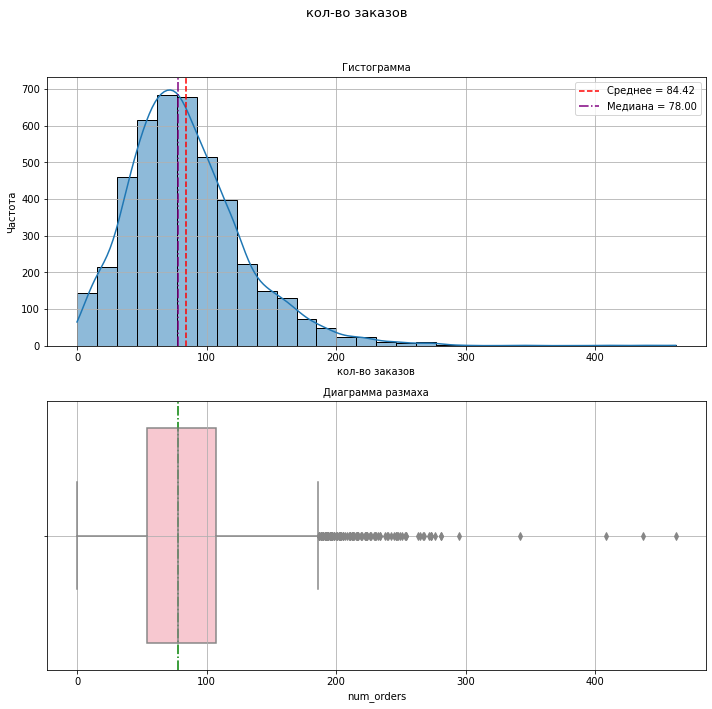

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [18]:
search_plot(df['num_orders'],'кол-во заказов',30)

По диаграмме можно сказать, что она смещена вправо, так как среднее значение выше медианы. Наблюдаются выбросы -- возможно что заказов со временем становится больше

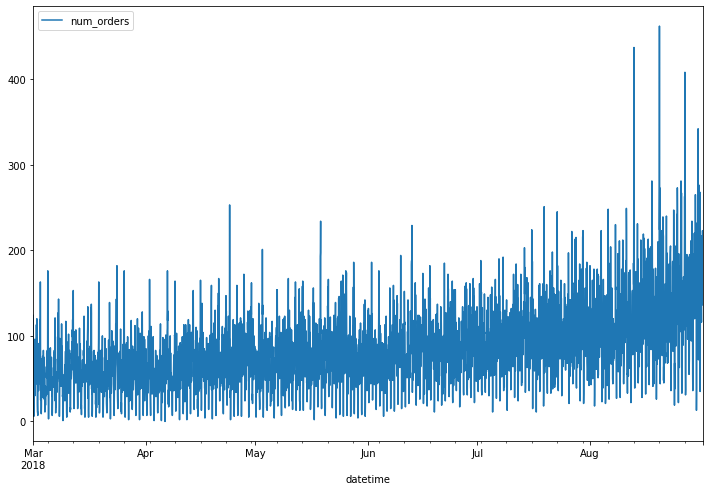

In [19]:
df.plot(figsize=(12, 8));

В почасовом графике нет возможности проанализировать график, поэтому для анализа сделаем ресемпл по дням

In [20]:
srch_1 = df.copy()

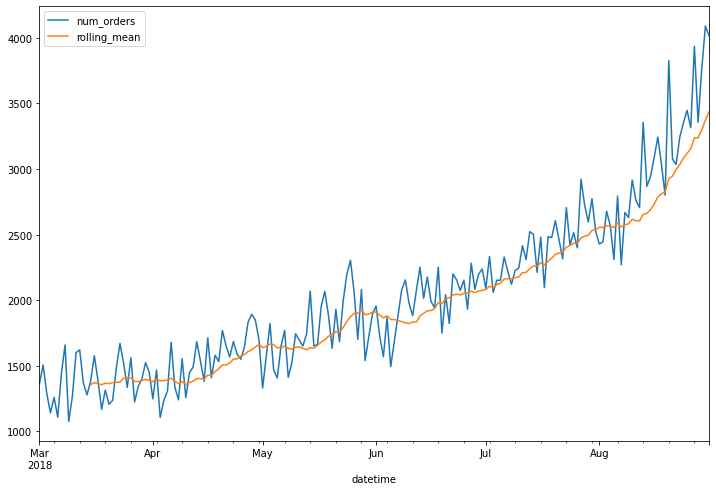

In [21]:
srch_1= srch_1.resample('1D').sum()
srch_1['rolling_mean'] = srch_1.rolling(15).mean()
srch_1.plot(figsize=(12, 8));

Нестационарный временной ряд, так как меняется среднее значение

In [22]:
decomposed = seasonal_decompose(srch_1['num_orders'])

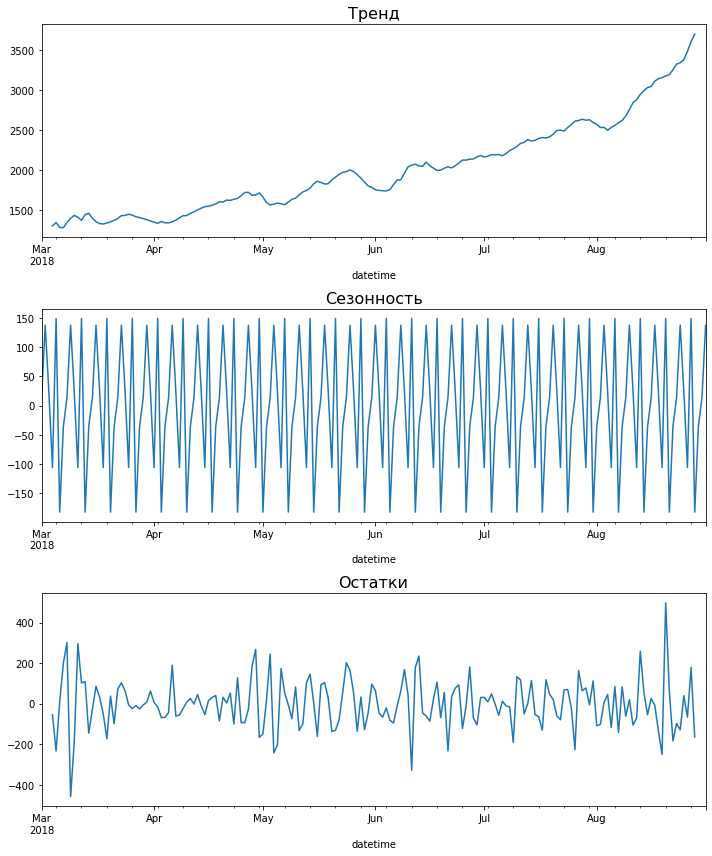

In [23]:
plt.figure(figsize=(10, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд',fontsize=16)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())  
plt.title('Сезонность',fontsize=16)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки',fontsize=16)
plt.tight_layout()

1) **Тренд** показывает устойчивый рост во времени с некоторыми незначительными колебаниями.Рост становится более выраженным к концу периода, что может говорить о ускорении тренда. Возможно из-за сезона отпусков или маркетинговыми афишами.      
2) **Сезонная компонента**: амплитуда и форма колебаний стабильны, что говорит о постоянном сезонном эффекте на протяжении всего периода     
3) **Остатки**: график характеризуется нерегулярными колебаниями без явной тенденции или повторяющихся паттернов

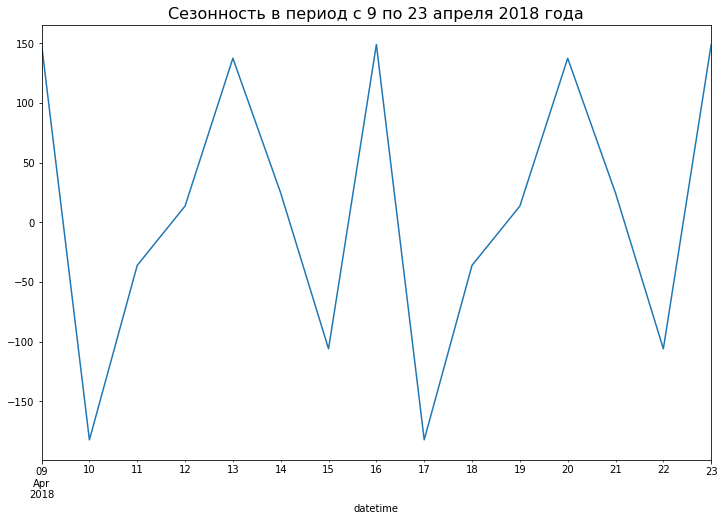

In [24]:
decomposed.seasonal['2018-04-09':'2018-04-23'].plot(figsize=(12, 8))
plt.title('Сезонность в период с 9 по 23 апреля 2018 года',fontsize=16);

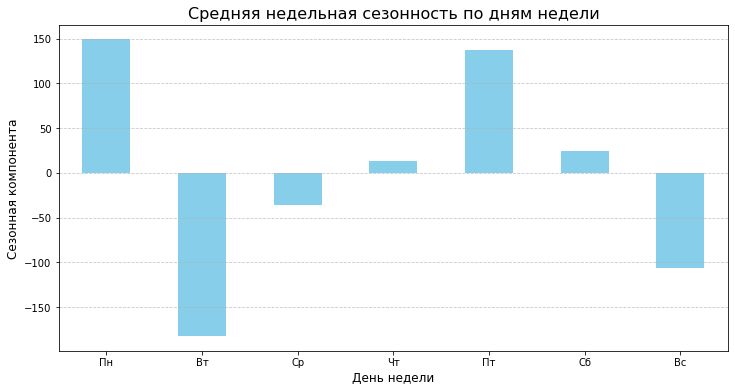

In [25]:
weekday_seasonal = decomposed.seasonal.groupby(decomposed.seasonal.index.dayofweek).mean()

# Создаем подписи для дней недели
weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

plt.figure(figsize=(12, 6))
weekday_seasonal.plot(kind='bar', color='skyblue')
plt.title('Средняя недельная сезонность по дням недели', fontsize=16)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Сезонная компонента', fontsize=12)
plt.xticks(range(7), weekday_names, rotation=0)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

По понедельникам и пятница виден всплеск заказов, а в воскресенье и вторник -> уменьшение     
Возможно это связано с рабочей неделей. В понедельник все прилетают на работу, а в пятницу возвращаются.

In [26]:
srch_2 = df.copy().resample('1D').sum()

In [27]:
srch_2 = srch_2 - srch_2.shift()

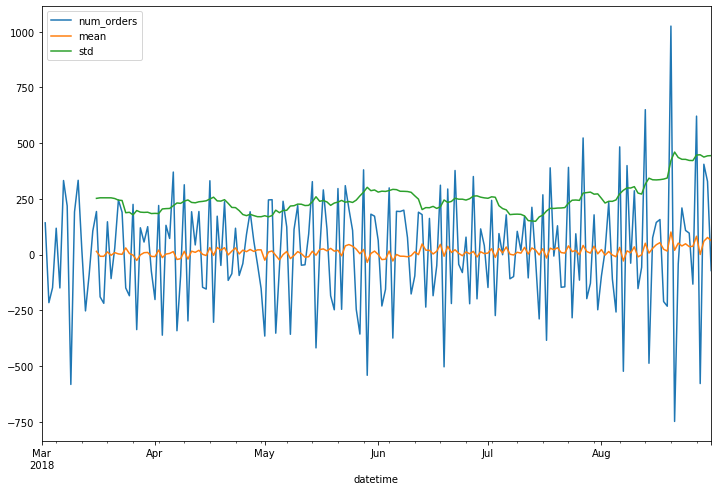

In [28]:
srch_2['mean'] = srch_2['num_orders'].rolling(15).mean()
srch_2['std'] = srch_2['num_orders'].rolling(15).std()
srch_2.plot(figsize=(12, 8));

Заметно что с августа идет увеличение стандартного отклонения и среднего значения. Как раз на те даты, которые придется предсказать в этом проекте

In [29]:
srch_3 = df.copy()

In [30]:
decomposed_2 = seasonal_decompose(srch_3['num_orders'])

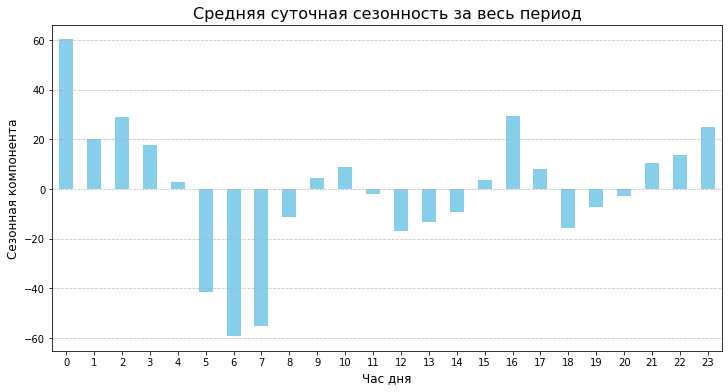

In [31]:
hourly_seasonal = decomposed_2.seasonal.groupby(decomposed_2.seasonal.index.hour).mean()

plt.figure(figsize=(12, 6))
hourly_seasonal.plot(kind='bar', color='skyblue')
plt.title('Средняя суточная сезонность за весь период', fontsize=16)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Сезонная компонента', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1) Основные пики заказов такси в аэропорту — в полночь и в середине/конце дня (около 15:00 и 23:00).    
2) Низкая активность в ранние утренние часы.

## Обучение

In [32]:
def make_features(data, max_lag, rolling_mean_size):
#    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
#        data['lag_power{}'.format(lag)] = data['num_orders'].shift(lag)**2
#        data['lag_sqrt{}'.format(lag)] = data['num_orders'].shift(lag)**0.5
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()    
#    data['rolling_mean_power'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()**0.5    
    data.dropna(inplace=True)    
    
     


In [33]:
t1 = df.copy()

In [34]:
make_features(t1,24,24)

### Подготовка данных

In [35]:
X = t1.drop(['num_orders'], axis=1)
y = t1['num_orders']

In [36]:
X_train, X_test, y_train, y_test = prepare_data(X, y)

In [37]:
print(f'''
-----Даты начала и конца тренировочной выборки-----
            {X_train.index[0]}
            {X_train.index[-1]}
-----Даты начала и конца тестовой выборки-----
            {X_test.index[0]}
            {X_test.index[-1]}
-----------------------------------------------
Размер тренировочной выборки:  {X_train.shape}
Размер тестовой выборки:       {X_test.shape}
    ''' )


-----Даты начала и конца тренировочной выборки-----
            2018-03-02 00:00:00
            2018-08-13 15:00:00
-----Даты начала и конца тестовой выборки-----
            2018-08-13 16:00:00
            2018-08-31 23:00:00
-----------------------------------------------
Размер тренировочной выборки:  (3952, 28)
Размер тестовой выборки:       (440, 28)
    


In [38]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()
ohe_columns = X_train.select_dtypes(include='object').columns.tolist()

In [39]:
param_grid_tree = [
    # Гиперпараметры DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 7, 10, None],
        'models__min_samples_leaf': [2, 4],
        'models__max_features': [0.5, 1]
    }
]
param_linear = [
     # Гиперпараметры LinearRegression
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True, False],
        'models__positive': [True, False]  
    }
]    

### Линейная регрессия

In [40]:
tscv = TimeSeriesSplit(n_splits=5)

In [41]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('models', LinearRegression())
])

In [42]:
gs_lr = GridSearchCV(
    pipeline, 
    param_linear, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=1
)

In [43]:
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('models', LinearRegression())]),
             n_jobs=1,
             param_grid=[{'models': [LinearRegression()],
                          'models__fit_intercept': [True, False],
                          'models__positive': [True, False]}],
             scoring='neg_root_mean_squared_error')

In [44]:
cv_results = []
best_score_lr = -gs_lr.best_score_  
print("Лучший RMSE:", best_score_lr)
cv_results.append({'RMSE_Linear_Regression':best_score_lr})

Лучший RMSE: 27.12133741684381


### Деревья

In [45]:
gs_tree = GridSearchCV(
    pipeline, 
    param_grid_tree, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [46]:
gs_tree.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': [3, 7, 10, None],
                          'models__max_features': [0.5, 1],
                          'models__min_samples_leaf': [2, 4]}],
             scoring='neg_root_mean_squared_error')

In [47]:
best_score_tree = -gs_tree.best_score_  
print("Лучший RMSE:", best_score_tree)
cv_results.append({'RMSE_Tree_regressor':best_score_tree})

Лучший RMSE: 29.3256281483924


### LightGBM

In [48]:
model_lgbm = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    n_estimators=100,
    random_state=42,
    verbose=-1  
)

In [49]:
param_grid_lgbm = {
    'learning_rate': [0.01, 0.1]
}

In [50]:
grid_lgbm = GridSearchCV(
    estimator=model_lgbm,
    param_grid=param_grid_lgbm,
    scoring='neg_root_mean_squared_error',  
    cv=tscv,  
    n_jobs=-1 
)

In [51]:
grid_lgbm.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(objective='regression', random_state=42,
                                     verbose=-1),
             n_jobs=-1, param_grid={'learning_rate': [0.01, 0.1]},
             scoring='neg_root_mean_squared_error')

In [52]:
best_score_lgbm = -grid_lgbm.best_score_  
print("Лучший RMSE:", best_score_lgbm)


Лучший RMSE: 25.182991984954597


In [53]:
cv_results.append({'RMSE_Light_GBM':best_score_lgbm})

### Catboost

In [54]:
model_catboost = CatBoostRegressor(verbose=False)

In [55]:
param_grid_catboost = {
    'depth': [3,5,7,10],  
    'learning_rate': [0.01, 0.1],  
    'iterations': [100, 500],  
    'l2_leaf_reg': [2, 5] 
}

In [56]:
gs_catboost = GridSearchCV(
    model_catboost, 
    param_grid_catboost, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [57]:
gs_catboost.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f859ae79640>,
             n_jobs=-1,
             param_grid={'depth': [3, 5, 7, 10], 'iterations': [100, 500],
                         'l2_leaf_reg': [2, 5], 'learning_rate': [0.01, 0.1]},
             scoring='neg_root_mean_squared_error')

In [58]:
best_score_cb = -gs_catboost.best_score_  
print("Лучший RMSE:", best_score_cb)


Лучший RMSE: 24.46651906700165


In [59]:
cv_results.append({'RMSE_CatBoost':best_score_cb})

## Тестирование

Так как CatBoost показал лучший результат на кросс валидации, в тесте будем использовать эту модель

In [60]:
cv_results

[{'RMSE_Linear_Regression': 27.12133741684381},
 {'RMSE_Tree_regressor': 29.3256281483924},
 {'RMSE_Light_GBM': 25.182991984954597},
 {'RMSE_CatBoost': 24.46651906700165}]

In [64]:
best_model = gs_catboost.best_estimator_
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\nРезультаты на тестовой выборке:")
print(f"RMSE: {test_rmse:.2f}")


Результаты на тестовой выборке:
RMSE: 40.66


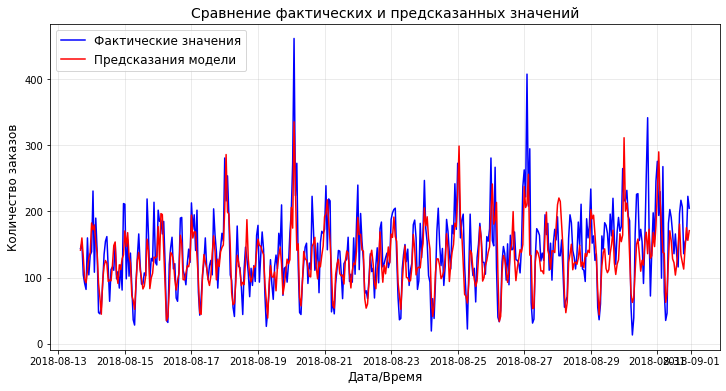

In [65]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.index, 
         y_test, 
         'b-', 
         label='Фактические значения')

plt.plot(y_test.index, 
         y_pred_test, 
         'r-', 
         label='Предсказания модели') 

plt.legend(
    loc='upper left',  
    fontsize=12,       
    framealpha=0.8     
)

plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
plt.xlabel('Дата/Время', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.grid(alpha=0.3)

plt.show()

Модель хорошо улавливает общие тренды и средние значения, но имеет сложности с точным предсказанием резких пиков и аномалий

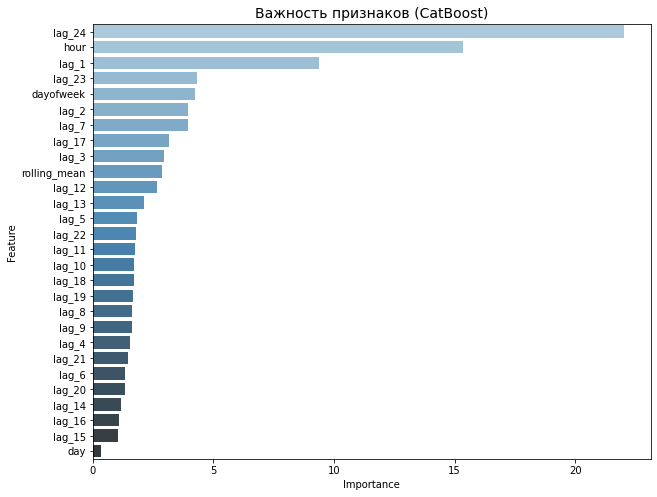

In [68]:
feature_importance = best_model.get_feature_importance()
feature_names = X_train.columns  

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
plt.title('Важность признаков (CatBoost)', fontsize=14)
plt.show()

## Итог

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

**Отчёт по прогнозированию заказов такси для компании "Чётенькое такси"**

**Цель проекта**
Прогнозирование количества заказов такси на следующий час для оптимального распределения водителей в аэропортах. Требуемое качество модели: RMSE ≤ 48 на тестовой выборке.

**Подготовка данных**
1. **Предобработка**:
   - Ресемплирование данных по 1 часу
   - Анализ данных
   - Создание признаков

**Результаты моделирования**

Сравнение моделей:      
- LinearRegression      RMSE: 27.1          
- Tree_regressor        RMSE:  29.3          
- LGBMRegressor     RMSE: 25.1    
- **CatBoost**              RMSE:  **24.46**            


    
**Лучшая модель: CatBoost**     
Метрика на тестовых данных составила  (RMSE = 40.66), что соответствует требованиям
    
**Анализ важности признаков**:
- Час дня (максимум в вечерние часы)
- Lag_24, Lag_1 (значение за предыдущие сутки/час)
- День недели (пики в понедельник и пятницу)
- Скользящее среднее (24-часовое окно)    
    
**Выводы**
    
Модель успешно прошла валидацию (RMSE меньше 48)

Особенности данных:

- Тестовая выборка показала более резкий рост заказов. Возможно из-за сезона отпусков в августе

- Ярко выраженная суточная и недельная сезонность

- Основные пики заказов такси в аэропорту — в полночь и в середине/конце дня (около 15:00 и 23:00)

